In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

In [3]:
tf.version.VERSION

'2.16.1'

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [5]:
CATEGORY_LIST = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen", "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill", "Sugar beet"]

In [6]:
train_size = 0
for i, category in enumerate(CATEGORY_LIST):
    train_size += len(os.listdir('data/train/' + category))

In [7]:
train_size

4750

In [8]:
for i, category in enumerate(CATEGORY_LIST):
    print("{} {} images".format(category, len(os.listdir('data/train/' + category))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [9]:
test_size = len(os.listdir('data/test'))
print(test_size)

794


In [10]:
NUM_CATEGORIES = len(CATEGORY_LIST)

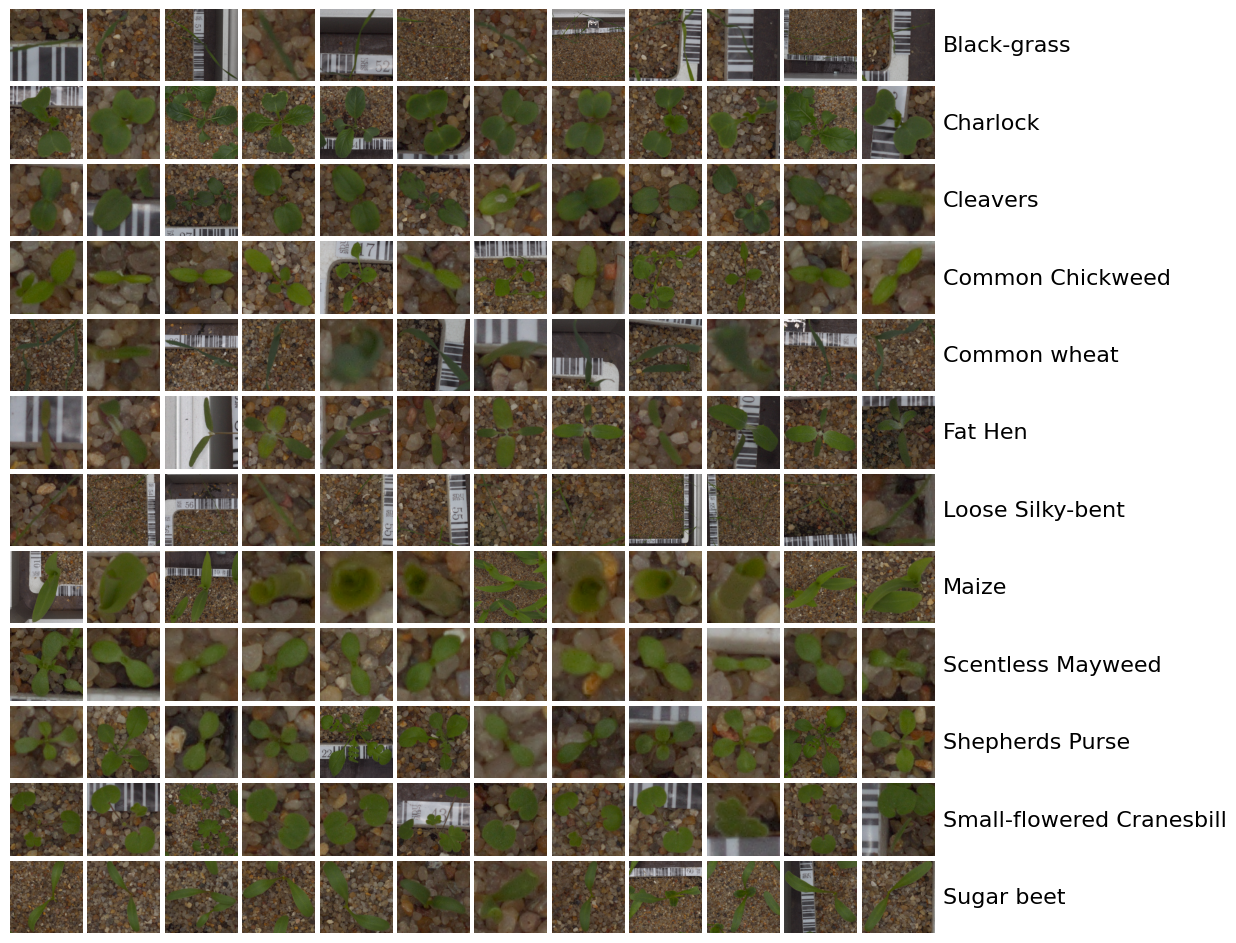

In [11]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category in CATEGORY_LIST:
    k = 0
    for image_name in os.listdir('data/train/' + category):
        ax = grid[i]
        img = tf.keras.preprocessing.image.load_img(f'data/train/{category}/{image_name}', target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, category, verticalalignment='center')
        i += 1
        k += 1
        if k >= NUM_CATEGORIES:
            break
plt.show()

In [12]:
INPUT_SIZE = 299

In [47]:
X_train = np.zeros((train_size, INPUT_SIZE, INPUT_SIZE, 3))
y_train = np.zeros((train_size, 12))
j = 0
for i, category in enumerate(CATEGORY_LIST):
    for image_name in os.listdir('data/train/' + category):
        # img = np.fromfile(f'./data/train/{train_class}/{train_image}', dtype="uint32")
        img = np.array(Image.open(f'./data/train/{category}/{image_name}').resize((INPUT_SIZE, INPUT_SIZE))) / 255.
        X_train[j] = img[:, :, :3]  # Keep only the first 3 channels (RGB)
        y_train[j, i] = 1
        j += 1

In [48]:
X_train.shape, y_train.shape

((4750, 299, 299, 3), (4750, 12))

In [51]:
X_train = None
y_train = None
for i, category in enumerate(CATEGORY_LIST):
    for train_image in os.listdir('data/train/' + category):
        img = np.array(Image.open(f'./data/train/{category}/{train_image}').resize((INPUT_SIZE, INPUT_SIZE))) / 255.
        X_train = np.column_stack((X_train, img[:, :, :3])) if X_train is not None else img
        y_train = np.hstack((y_train, np.array([i]))) if y_train is not None else np.array([i])

In [52]:
X_train.shape, y_train.shape

((128, 608000, 3), (4750,))

In [13]:
X_train = np.zeros((train_size, INPUT_SIZE, INPUT_SIZE, 3))
y_train = np.zeros((train_size, 12))
j = 0
for i, category in enumerate(CATEGORY_LIST):
    for image_name in os.listdir('data/train/' + category):
        img = tf.keras.preprocessing.image.load_img(f'data/train/{category}/{image_name}', target_size=(INPUT_SIZE, INPUT_SIZE))
        img = tf.keras.preprocessing.image.img_to_array(img)
        X_train[j] = img
        y_train[j, i] = 1
        j += 1

In [14]:
X_train.shape, y_train.shape

((4750, 299, 299, 3), (4750, 12))

In [16]:
# Sum by column
np.sum(y_train, axis=0)

array([263., 390., 287., 611., 221., 475., 654., 221., 516., 231., 496.,
       385.])

In [21]:
pd.DataFrame(np.sum(y_train, axis=1)).value_counts()

0  
1.0    4750
Name: count, dtype: int64

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [24]:
pretained_inception = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [25]:
pretained_inception.trainable = False

In [26]:
model_inception = tf.keras.models.Sequential([
    pretained_inception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(12, activation='softmax')
])

In [27]:
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.F1Score(average='micro')])

In [30]:
model_inception.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
model_inception.save('models/model_inception.h5')